In [1]:
# load required libraries
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np

num_features = 53 #Number of features in the dataset
lag_steps = 1 #Number of lagged time features to be generated
label_feature = 'POILBRE' #The column in dataset that model is being built to predict

Using TensorFlow backend.


In [2]:
# This function arranges the dataset to be used for surpervised learning by shifting the input values of features by the number
# time steps given in lag_steps

def sequential_to_supervised(data, lag_steps = 1, n_out = 1, dropnan = True):
    features = 1 if type(data) is list else data.shape[1] # Get the number of features in dataset
    df = DataFrame(data)
    cols = list()
    feature_names = list()
    
    for i in range(lag_steps, 0, -1):
        cols.append(df.shift(i)) # This will be the shifted dataset
        feature_names += [(str(df.columns[j])) + '(t-%d)' % (i) for j in range(features)] # Names of the shifted features
    
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            feature_names += [(str(df.columns[j])) + '(t)'  for j in range(features)] # Names of the shifted features
        else:
            feature_names += [(str(df.columns[j])) + '(t+%d)' % (i) for j in range(features)] # Names of the shifted features
    
    agg = concat(cols, axis=1) 
    agg.columns = feature_names
    
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
# Reading in the dataset which is in .csv format, has column headings and has an index column
dataset = read_csv("Dataset.csv", header = 0, index_col = 0, squeeze = True, usecols = [i for i in range(0, num_features+1))]
supervised_dataset = sequential_to_supervised(dataset, lag_steps)

# Move label column to the end of dataset
cols_at_end = [label_feature + '(t)']
supervised_dataset = supervised_dataset[[c for c in supervised_dataset if c not in cols_at_end] + [c for c in cols_at_end if c in supervised_dataset]]

#print(supervised_dataset.shape)  # Used for debugging

In [4]:
# Dropping the current timestep columns of features other than the one being predicted, which will be the label or y 
supervised_dataset.drop(supervised_dataset.columns[(num_features*lag_steps) : (num_features*lag_steps + num_features -1)], axis=1, inplace=True)
#print(supervised_dataset.shape) # Used for debugging
scaler = MinMaxScaler(feature_range=(0, 1))
supervised_dataset_scaled = scaler.fit_transform(supervised_dataset) # Scaling all values

In [5]:
split = int(supervised_dataset_scaled.shape[0]*0.8) # Splitting for traning and testing
train = supervised_dataset_scaled[:split, :]
test = supervised_dataset_scaled[split:, :]

train_X, train_y = train[:, :-1], train[:, -1] # The label column is separated out
test_X, test_y = test[:, :-1], test[:, -1]
#print(train_X.shape) # Used for debugging
#print(test_X.shape) # Used for debugging
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1])) # Reshaping done for LSTM as it need 3D input
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#print(train_X.shape) # Used for debugging
#print(test_X.shape) # Used for debugging

Train on 234 samples, validate on 59 samples
Epoch 1/70
 - 2s - loss: 0.4108 - val_loss: 0.5913
Epoch 2/70
 - 0s - loss: 0.3171 - val_loss: 0.4388
Epoch 3/70
 - 0s - loss: 0.2201 - val_loss: 0.2878
Epoch 4/70
 - 0s - loss: 0.1449 - val_loss: 0.1728
Epoch 5/70
 - 0s - loss: 0.0984 - val_loss: 0.1510
Epoch 6/70
 - 0s - loss: 0.0891 - val_loss: 0.1495
Epoch 7/70
 - 0s - loss: 0.1246 - val_loss: 0.1745
Epoch 8/70
 - 0s - loss: 0.1457 - val_loss: 0.1758
Epoch 9/70
 - 0s - loss: 0.1405 - val_loss: 0.1542
Epoch 10/70
 - 0s - loss: 0.1188 - val_loss: 0.1460
Epoch 11/70
 - 0s - loss: 0.0968 - val_loss: 0.1467
Epoch 12/70
 - 0s - loss: 0.0863 - val_loss: 0.1483
Epoch 13/70
 - 0s - loss: 0.0853 - val_loss: 0.1490
Epoch 14/70
 - 0s - loss: 0.0841 - val_loss: 0.1468
Epoch 15/70
 - 0s - loss: 0.0790 - val_loss: 0.1425
Epoch 16/70
 - 0s - loss: 0.0722 - val_loss: 0.1375
Epoch 17/70
 - 0s - loss: 0.0699 - val_loss: 0.1337
Epoch 18/70
 - 0s - loss: 0.0714 - val_loss: 0.1305
Epoch 19/70
 - 0s - loss: 0.

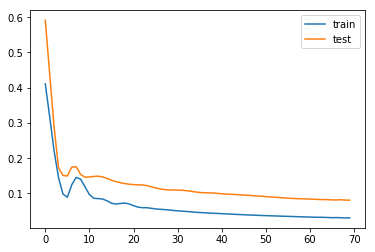

In [6]:
# Defining the LSTM model to be fit
model = Sequential()
model.add(LSTM(85, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# Fitting the model
history = model.fit(train_X, train_y, epochs=70, batch_size=175, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# Plotting the training progression
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [7]:
# Using the trained model to predict the label values in test dataset
yhat = model.predict(test_X)

#print(yhat.shape) # Used for debugging
#print(test_X.shape) # Used for debugging

# Reshaping back into 2D for inversing the scaling
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2])) 
#print(test_X.shape) # Used for debugging

In [8]:
# Concatenating the predict label column with Test data input features, needed for inversing the scaling
inv_yhat = concatenate((test_X[:, 0:], yhat), axis=1) 
inv_yhat = scaler.inverse_transform(inv_yhat) # Rescaling back
#print(inv_yhat.shape) # Used for debugging
inv_yhat = inv_yhat[:, num_features*lag_steps] # Extracting the rescaled predicted label column

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, 0:], test_y), axis=1) # Re joing the test dataset for inversing the scaling
inv_y = scaler.inverse_transform(inv_y) # Rescaling the actual label column values
inv_y = inv_y[:, num_features*lag_steps] # Extracting the rescaled actual label column

rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat)) # Calculating RMSE
print('Test RMSE: %.3f' % rmse)

Test RMSE: 11.406


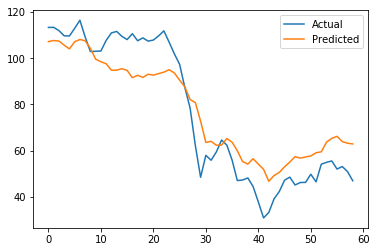

In [9]:
pyplot.plot(inv_y, label = 'Actual')
pyplot.plot(inv_yhat, label = 'Predicted')
pyplot.legend()
pyplot.show()